In [1]:
import numpy as np                          # library to support matrix computations
import pandas as pd                         # library for data manipulation and analysis
import json
import copy
from os import listdir
import re
from scipy.linalg import eig                # linear algebra functions
import matplotlib.pyplot as plt
from string import ascii_uppercase
import unidecode
from pprint import pprint


In [2]:
def pca(X):
    ''' Principal Components Analysis '''
    cov_matrix = np.cov(X.T) # Transpose b/c np.cov assumes row vars.
    evals, evecs = eig(cov_matrix)
    idcs = np.argsort(evals)[::-1]
    evecs = evecs.real[:, idcs]
    evals = evals.real[idcs]

    return evecs, evals

In [3]:
def to_slug(x):
    return x.lower().replace(' ','-')


In [4]:
def to_safe(x):
    return x.replace('ö','o')

In [5]:
def preprocess(df):

    old_vals = ['Strongly Disagree',
                'Disagree',
                'Uncertain',
                'Agree',
                'Strongly Agree',
                'No Opinion',
                'Did Not Answer',
                'Did Not Vote',
                'Did not answer',
                None]
    new_vals = [-1.5,
                -1,
                0,
                1,
                1.5,
                np.nan,
                np.nan,
                np.nan,
                np.nan,
                np.nan]

    df = df.replace(old_vals, new_vals)

    # Only retain responders with > 75% response rate
    num_questions = len(df.columns)
    df = df[df.notnull().sum(axis=1) > (num_questions * 0.75)]

    # Replace remaining nans with the column mean
    df = df.fillna(df.mean())

    df = df.sort_index()
    return df

In [6]:
year = '2021'
survey_dir = 'surveys'

In [7]:
fnames_to_slugs = {
    '2021-01-01-US-EEP-Bah-Humbug.csv':'bah-humbug',
    '2021-01-01-US-EEP-Balanced-Budget-Amendment.csv':'balanced-budget-amendment',
    '2021-01-01-US-EEP-Baumols-Cost-Disease.csv':'baumols-cost-disease',
    '2021-01-01-US-EEP-Breaking-Up-Large-Tech-Companies.csv':'breaking-up-large-tech-companies',
    '2021-01-01-US-EEP-Christmas-Spending.csv':'christmas-spending',
    '2021-01-01-US-EEP-Climate-Change-Policies-a.csv':'climate-change-policies-a',
    '2021-01-01-US-EEP-Climate-Change-Policies-b.csv':'climate-change-policies-b',
    '2021-01-01-US-EEP-College-Admissions.csv':'college-admissions',
    '2021-01-01-US-EEP-Corporate-Social-Responsibility.csv':'corporate-social-responsibility',
    '2021-01-01-US-EEP-Currency-Manipulation.csv':'currency-manipulation',
    '2021-01-01-US-EEP-Deficits.csv':'deficits',
    '2021-01-01-US-EEP-Economic-Policy-Advice.csv':'economic-policy-advice',
    '2021-01-01-US-EEP-Executive-Pay.csv':'executive-pay',
    '2021-01-01-US-EEP-Free-Trade.csv':'free-trade',
    '2021-01-01-US-EEP-Gold-Standard.csv':'gold-standard',
    '2021-01-01-US-EEP-Market-Share-Market-Power.csv':'market-share-market-power',
    '2021-01-01-US-EEP-Modern-Monetary-Theory.csv':'modern-monetary-theory',
    '2021-01-01-US-EEP-Obesity-Soft-Drinks.csv':'obesity-soft-drinks',
    '2021-01-01-US-EEP-Occupational-Licensing.csv':'occupational-licensing',
    '2021-01-01-US-EEP-Oil-Price-Speculation.csv':'oil-price-speculation',
    '2021-01-01-US-EEP-Patents.csv':'patents',
    '2021-01-01-US-EEP-Payday-Lending.csv':'payday-lending',
    '2021-01-01-US-EEP-Poverty-Measurement.csv':'poverty-measurement',
    '2021-01-01-US-EEP-Prices-of-Medical-Supplies.csv':'prices-of-medical-supplies',
    '2021-01-01-US-EEP-Quarterly-Earnings.csv':'quarterly-earnings',
    '2021-01-01-US-EEP-Ranked-choice-Voting.csv':'ranked-choice-voting',
    '2021-01-01-US-EEP-Robots-Artifical-Intelligence.csv':'robots-artifical-intelligence',
    '2021-01-01-US-EEP-Sports-Betting.csv':'sports-betting',
    '2021-01-01-US-EEP-Sports-Stadiums.csv':'sports-stadiums',
    '2021-01-01-US-EEP-Stakeholder-Capitalism-a.csv':'stakeholder-capitalism-a',
    '2021-01-01-US-EEP-Stakeholder-Capitalism-b.csv':'stakeholder-capitalism-b',
    '2021-01-01-US-EEP-State-run-Lotteries.csv':'state-run-lotteries',
    '2021-01-01-US-EEP-Stock-Prices.csv':'stock-prices',
    '2021-01-01-US-EEP-Subsidies-to-Attract-Businesses.csv':'subsidies-to-attract-businesses',
    '2021-01-01-US-EEP-Supplying-Kidneys.csv':'supplying-kidneys',
    '2021-01-01-US-EEP-Surge-Pricing.csv':'surge-pricing',
    '2021-01-01-US-EEP-Textbook-Prices.csv':'textbook-prices',
    '2021-01-01-US-EEP-The-Dollar.csv':'the-dollar',
    '2021-01-01-US-EEP-Ticket-Resale.csv':'ticket-resale',
    '2021-01-01-US-EEP-Trade-Deals.csv':'trade-deals',
    '2021-01-01-US-EEP-Trade-Exchange-Rates.csv':'trade-exchange-rates',
    '2021-01-01-US-EEP-Unemployment-US-Economy.csv':'unemployment-us-economy',
    }

In [8]:
fnames = sorted(fnames_to_slugs.keys())
qdfs = []
slugs = []
answers = {}
for fname in fnames:
    # pprint(survey_dir)
    qdf = pd.read_csv(survey_dir + '/' + fname)
    qdf = qdf.set_index(qdf['First Name'].str.cat(qdf['Last Name'], sep=' '))
    drop_columns = [col for col in qdf.columns if 'Confidence in this topic' in col or 'Please explain your' in col or 'Unnamed' in col]
    drop_columns += ['First Name', 'Last Name']
    qdf = qdf.drop(columns=drop_columns)
    qdf = qdf[qdf.index.notnull()]
    n_cols = len(qdf.columns)
    if n_cols > 1:
        qdf.columns = [f"Part {ascii_uppercase[i]}: {col}" for i, col in enumerate(qdf.columns)]
    qdfs += [qdf]
    for col in qdf.columns:
        slugs += [fnames_to_slugs[fname]]
df = pd.concat(qdfs, axis=1)
df.columns = [f"{i+1}. {col}" for i, col in enumerate(df.columns)]      # what does the final data strucutre look like?
print('-----')
pprint(df)
print('-----')
print(type(df))


-----
                    1. Giving specific presents as holiday gifts is inefficient, because recipients could satisfy their preferences much better with cash.  \
First Name                                                                                                                                                   
Daron Acemoglu                                                Disagree                                                                                       
Alberto Alesina                                      Strongly Disagree                                                                                       
Joseph Altonji                                                Disagree                                                                                       
Alan Auerbach                                                Uncertain                                                                                       
David Autor                                   

In [9]:
df = preprocess(df)
# print(df.iloc[:,1].to_json())
# print(df.iloc[:, 0].to_json())
# df = df.replace(old_vals, slugs)
df2=copy.deepcopy(df)
df2.columns=slugs
df2.index = df2.index.map(to_slug)
# print(df2)
# df2=df2.transpose()
# print(df2.to_json())

In [10]:
for slug in slugs:
    print(slug)

bah-humbug
balanced-budget-amendment
baumols-cost-disease
breaking-up-large-tech-companies
christmas-spending
climate-change-policies-a
climate-change-policies-b
college-admissions
corporate-social-responsibility
currency-manipulation
deficits
economic-policy-advice
executive-pay
free-trade
gold-standard
market-share-market-power
modern-monetary-theory
obesity-soft-drinks
occupational-licensing
oil-price-speculation
patents
payday-lending
poverty-measurement
prices-of-medical-supplies
quarterly-earnings
ranked-choice-voting
robots-artifical-intelligence
sports-betting
sports-stadiums
stakeholder-capitalism-a
stakeholder-capitalism-b
state-run-lotteries
stock-prices
subsidies-to-attract-businesses
supplying-kidneys
surge-pricing
textbook-prices
the-dollar
ticket-resale
trade-deals
trade-exchange-rates
unemployment-us-economy


In [11]:
X_raw = np.array(df).astype(float)
print(X_raw)
q_means = X_raw.mean(axis=0)
q_sds = X_raw.std(axis=0)


[[ 0.         -1.5         1.         ...  1.         -1.5
   1.        ]
 [-1.5         1.          1.5        ...  0.         -1.5
   1.        ]
 [ 1.         -1.          1.5        ...  1.         -1.5
   1.        ]
 ...
 [-1.         -1.5         1.5        ...  0.20833333 -1.
   1.        ]
 [ 1.         -1.          1.         ...  0.20833333 -1.
   0.        ]
 [-1.         -1.5        -1.         ...  1.         -1.5
   1.5       ]]


In [12]:
# Separate responder IDs from row names
responder_ids = list(range(len(df)))

# Compute +/- 2SD for each question. For yellow highlights.
X_raw = np.array(df).astype(float)
q_means = X_raw.mean(axis=0)
q_sds = X_raw.std(axis=0)
igm_top_range =    2 * q_sds # Responses will be centered with q_means in .js
igm_bot_range = (-2) * q_sds # Responses will be centered with q_means in .js

# Centering the questions
X = X_raw - X_raw.mean(axis=0)

# Run PCA and compute 2D projection
evecs, evals = pca(X)

In [13]:
# Sign flipping so politically left is on the left
if year == '2021':
    evecs[:,0] = evecs[:,0] #X
    evecs[:,1] = -evecs[:,1]

# Compute each economists projection in 2D space.
proj = np.dot(X, evecs[:, 0:2])
print(proj)
# User info dict
user_info = {'name': 'You',
             'x': 0,
             'y': 0,
             'responder_id': 0}

[[-1.86650933 -0.36157101]
 [ 3.69656562 -4.67972764]
 [-2.26451667 -0.11100348]
 [ 0.33804832  0.42843564]
 [ 0.99822174  0.60771945]
 [-0.58191788 -0.49879618]
 [ 1.51289327  0.83787537]
 [ 1.80087506  0.39039121]
 [-0.49433585  0.40060392]
 [-0.21220583  1.52590292]
 [ 1.73514685 -2.4491952 ]
 [ 2.35638999  2.41323617]
 [ 1.64073838  0.38852453]
 [-0.05436281  0.20691145]
 [-1.40502174  0.26982259]
 [-1.3127103  -0.59691346]
 [ 2.39149193 -1.22790763]
 [ 2.2298055   0.54604255]
 [-2.77039752 -1.35767882]
 [ 0.45128291  0.84790412]
 [-1.25143905  2.17270211]
 [-0.32814546 -0.28269492]
 [-1.13302503  1.12524506]
 [ 2.07133999  1.10342021]
 [-2.12343246 -1.0420827 ]
 [-3.21695228 -0.23895957]
 [-3.77244964 -1.55104994]
 [ 1.56462229  1.13284326]]


In [14]:
# Get correlation matrix, sorted by position on x-axis.
pc1_order = np.argsort(proj[:, 0])
print(pc1_order)
print(X_raw[pc1_order, :])
corr_mat = np.corrcoef(X_raw[pc1_order, :])
print(corr_mat)
# List of responder info dicts, including user dict
points = [user_info]
assert(len(df)==len(proj))
for i in range(len(proj)):
    responder_info = {'name': df.index[i],
                      'x': proj[i, 0],
                      'y': proj[i, 1],
                      'short_name': unidecode.unidecode(df.index[i].lower().replace(' ', '-')),
                      'pc1_order': int(np.argwhere(pc1_order == i))}
    points.append(responder_info)

[26 25 18  2 24  0 14 15 20 22  5  8 21  9 13  3 19  4  6 27 12 10  7 23
 17 11 16  1]
[[ 1.         -1.          1.         ...  0.20833333 -1.
   0.        ]
 [-1.         -1.5         1.5        ...  0.20833333 -1.
   1.        ]
 [ 1.         -1.          1.         ...  1.         -1.
   1.        ]
 ...
 [ 0.         -1.5         1.         ...  0.          0.
   1.        ]
 [-1.5        -1.          1.5        ...  0.20833333 -1.
   1.        ]
 [-1.5         1.          1.5        ...  0.         -1.5
   1.        ]]
[[ 1.          0.7106861   0.592224    0.58821255  0.65955292  0.6019738
   0.49809271  0.48975335  0.47168261  0.51749003  0.47961333  0.46729467
   0.38464449  0.40163328  0.4055347   0.45841257  0.29169683  0.31694421
   0.33681996  0.13130984  0.2989206   0.35377788  0.26535473  0.15938419
   0.07532121  0.06022723  0.22664923 -0.0128186 ]
 [ 0.7106861   1.          0.63707904  0.61802002  0.54897725  0.69348912
   0.48784501  0.52256378  0.44424416  0.6118082

In [15]:
out = {}
out['points'] = points
out['q_slugs'] = slugs
print(df.columns)
out['questions'] = [re.sub(r"\(0+", "(", col) for col in df.columns]
out['answers'] = df2.to_dict()
out['q_means'] = list(q_means)
out['xweights'] = list(evecs[:, 0])
out['yweights'] = list(evecs[:, 1])
out['X'] = [['%.2f' % el for el in row] for row in X.tolist()]
out['corr_mat'] = [['%.2f' % el for el in row]
                   for row in corr_mat.tolist()]
out['igm_top_range'] = ['%.2f' % el for el in igm_top_range]
out['igm_bot_range'] = ['%.2f' % el for el in igm_bot_range]

Index(['1. Giving specific presents as holiday gifts is inefficient, because recipients could satisfy their preferences much better with cash.',
       '2. Amending the Constitution to require that the federal government end each fiscal year without a deficit would substantially reduce output variability in the United States.',
       '3. Because labor markets across different sectors are connected, rising productivity in manufacturing leads the cost of labor-intensive services — such as education and health care — to rise.',
       '4. Large tech platforms, such as Amazon Marketplace and Google Search, should be designated as ‘platform utilities' and broken apart from any participant on that platform.',
       '5. An annual December spending surge on parties, gift-giving and personal travel delivers net social benefits.',
       '6. Considering a broad range of costs and benefits is a better tool for guiding climate policy than setting temperature limits (such as 1.5 °C , eg) based on

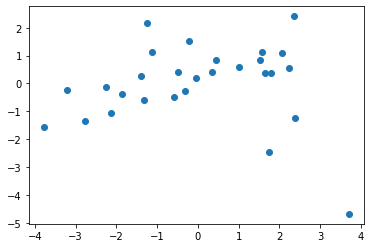

In [16]:
# Write to file
f = open("pca_results_" + year + ".json", "w")
json.dump(out, f, indent=2)
f.close()

# Plot responders in 2D space
plt.figure()
plt.scatter(proj[:, 0], proj[:, 1])
plt.show()